<a href="https://colab.research.google.com/github/bpandey369/AQI-Thesis/blob/main/Thesis_v7_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('/content/Main_AQI_v5.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

ValueError: ignored

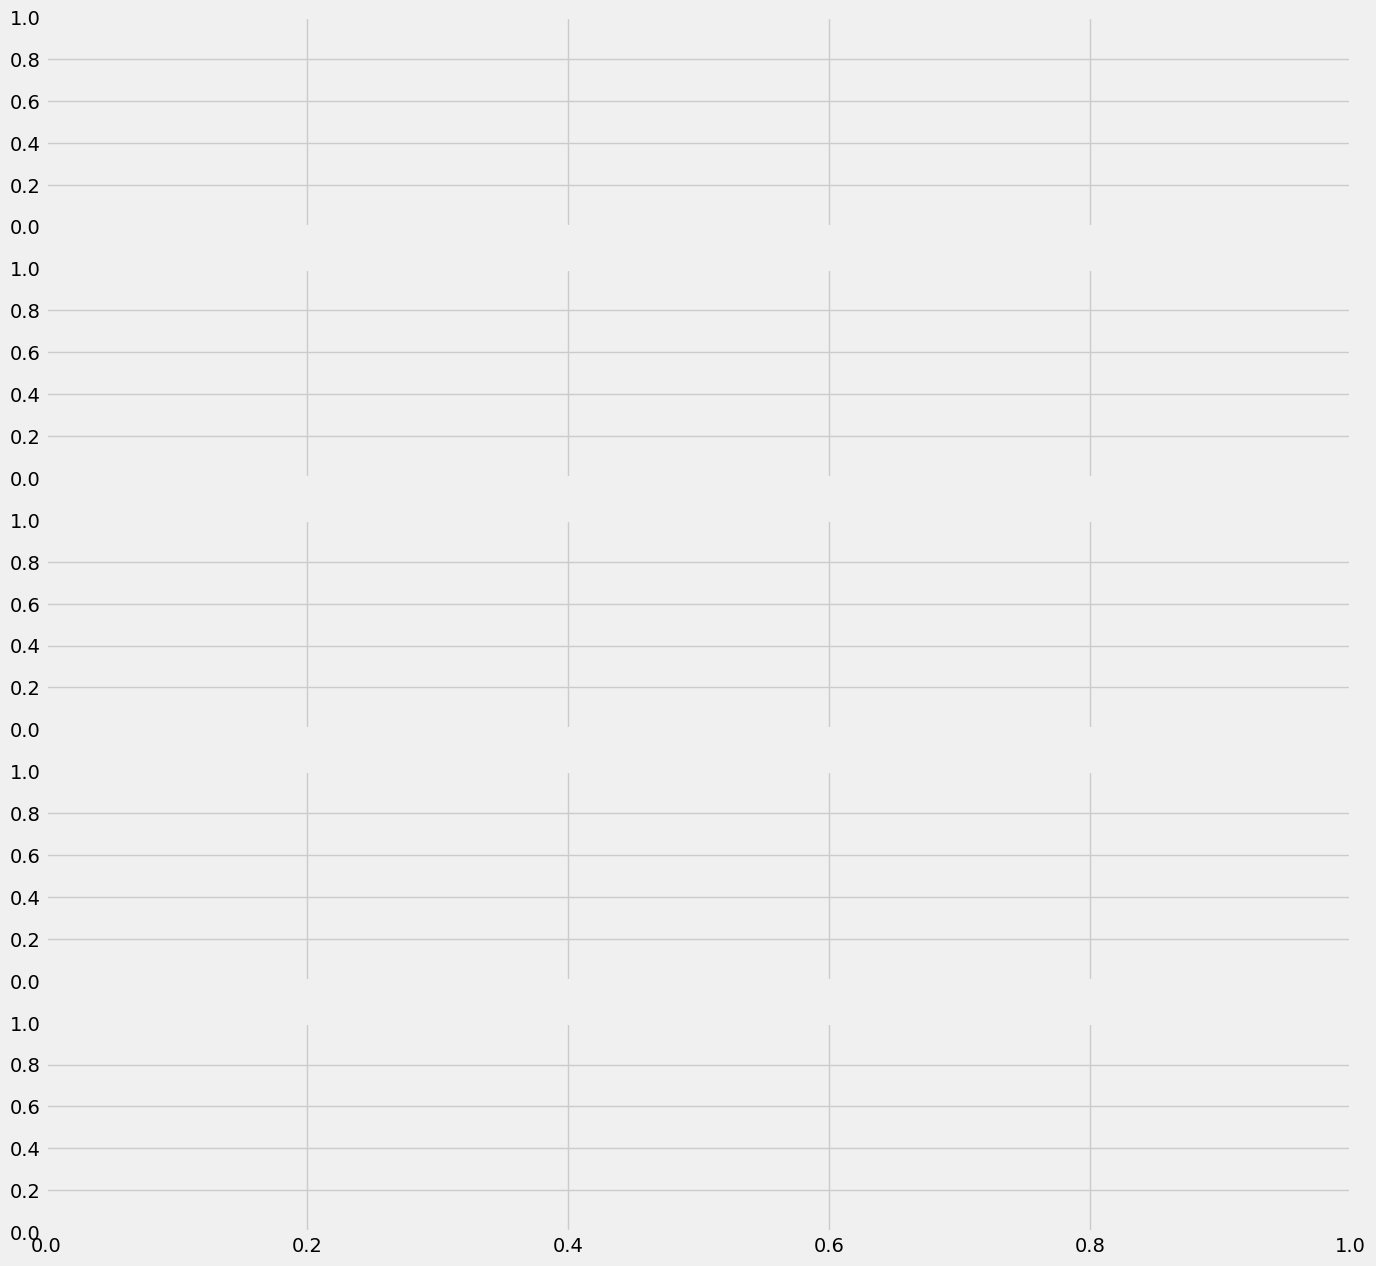

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AQI'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AQI'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
def add_lags(df):
    target_map = df['AQI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
df

,pm_cast,pm_aqi_category,pm_raw,pm_qc,o3_cast,o3_aqi_category,o3_raw,o3_qc,temp,visibility,...,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
2017-03-01 00:00:00,134.9,Unhealthy,146.0,Valid,4.000000,Good,4.0,Valid,286.46,3000.0,...,2,1,3,2017,60,1,9,NaN,NaN,NaN
2017-03-01 01:00:00,144.5,Unhealthy,154.0,Valid,2.000000,Good,2.0,Valid,286.64,1000.0,...,2,1,3,2017,60,1,9,NaN,NaN,NaN
2017-03-01 02:00:00,134.0,Unhealthy,122.0,Valid,8.000000,Good,8.0,Valid,288.34,1000.0,...,2,1,3,2017,60,1,9,NaN,NaN,NaN
2017-03-01 03:00:00,125.9,Unhealthy,114.0,Valid,6.000000,Good,6.0,Valid,289.13,1500.0,...,2,1,3,2017,60,1,9,NaN,NaN,NaN
2017-03-01 04:00:00,128.0,Unhealthy,131.0,Valid,8.000000,Good,8.0,Valid,289.91,1000.0,...,2,1,3,2017,60,1,9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-09 06:00:00,50.1,Unhealthy for Sensitive Groups,43.0,Valid,23.333797,NaN,11.0,Valid,294.19,6000.0,...,1,2,4,2019,99,9,15,162.0,182.0,NaN
2019-04-09 07:00:00,44.6,Unhealthy for Sensitive Groups,37.0,Valid,24.148156,NaN,9.0,Valid,294.99,6000.0,...,1,2,4,2019,99,9,15,169.0,192.0,NaN
2019-04-09 08:00:00,46.8,Unhealthy for Sensitive Groups,50.0,Valid,27.928569,NaN,4.0,Valid,295.59,7000.0,...,1,2,4,2019,99,9,15,168.0,211.0,NaN


In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','pm_raw',
                'o3_raw', 'visibility', 'dew_point','feels_like', 'pressure', 'humidity','rain_1h', 'clouds_all',
                'lag1','lag2','lag3']
    TARGET = 'AQI'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

ValueError: ignored

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds nan
Fold scores:[]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','pm_raw','o3_raw',
            'visibility', 'dew_point','feels_like', 'pressure', 'humidity','rain_1h', 'clouds_all',
            'lag1','lag2','lag3']
TARGET = 'AQI'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

In [ ]:
df.index.max()

In [ ]:
# Create future dataframe
future = pd.date_range('2023-09-11','2024-12-30', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [ ]:
df_model = future_w_features['pred']

In [ ]:
df_model.to_csv('model_data.csv')

In [ ]:
future_w_features['pred']['2023-09-29 11:00:00']

In [ ]:
import pickle

In [ ]:
with open('model.pkl', 'wb') as file:
    pickle.dump(reg_new, file)

In [ ]:
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
features = ['pm_raw',
       'o3_raw', 'visibility', 'dew_point',
       'feels_like', 'pressure', 'humidity','rain_1h', 'clouds_all','year', 'month', 'day', 'hour']

In [ ]:
target = 'AQI'

In [ ]:
train_size = int(0.8 * len(df))
train_data, test_data = df[:train_size], df[train_size:]


In [ ]:
train_dmatrix = xgb.DMatrix(train_data[features], label=train_data[target])
test_dmatrix = xgb.DMatrix(test_data[features], label=test_data[target])


In [ ]:
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',            # Root Mean Squared Error as evaluation metric
    'max_depth': 5,                   # Maximum depth of each tree
    'learning_rate': 0.1,             # Learning rate
    'num_boost_round': 100            # Number of boosting rounds
}


In [ ]:
model = xgb.train(params, train_dmatrix, num_boost_round=params['num_boost_round'])

In [ ]:
predictions = model.predict(test_dmatrix)

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data[target], predictions))
print(f'Root Mean Squared Error: {rmse}')

In [ ]:
predictions

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], test_data[target], label='Actual', marker='o')
plt.plot(test_data['date'], predictions, label='Predicted', marker='o')
plt.xlabel('Datetime')
plt.ylabel('Target Variable')
plt.legend()
plt.show()








In [ ]:
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score
import numpy as np
mse = mean_squared_error(test_data[target], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[target], predictions)
r2 = r2_score(test_data[target], predictions)

print('RMSE: ',rmse)
print('MAE: ',mae)
print('R2 Score: ',r2)

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(train_data['date'], train_data[target],label = "Train")
plt.plot(test_data['date'], test_data[target],label = "Test")
plt.plot(test_data['date'], predictions,label = "Predict")
plt.xlabel('Datetime')
plt.ylabel('Target Variable')

plt.legend()
plt.show()

In [ ]:
df[df.index == df.index.max()]

In [ ]:
future = pd.date_range('2023-09-11 01:00:00','2023-10-11 01:00:00',freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])

In [ ]:
df_and_future.sample()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


In [ ]:
df_and_future = create_features(df_and_future)

In [ ]:
df_and_future.sample()

In [ ]:
def add_lags(df):
    target_map = df['AQI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:

future_w_features

In [ ]:
model.predict(future_w_features[])

In [ ]:
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [ ]:
model

# Temporal Fusion Transformers(TFT)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


In [ ]:
train_size = int(0.8 * len(df))
train_data, test_data = df[:train_size], df[train_size:]


In [ ]:
input_dim = len(features)
output_dim = 1  # Assuming you are forecasting a single time series
sequence_length = 30

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(sequence_length, input_dim)),
    layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(50, activation="relu"),
    layers.Dense(output_dim)
])


In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length][features].values)
        target.append(data[i+sequence_length:i+sequence_length+1][target].values)
    return np.array(sequences), np.array(target)